In [ ]:
!mkdir -p data
!curl https://drive.google.com/drive/folders/0B7EVK8r0v71pWEZsZE9oNnFzTm8?resourcekey=0-5BR16BdXnb8hVj6CNHKzLg&usp=sharing -o data/celeba.zip
!unzip data/celeba.zip

In [1]:
cd ~/sheen

/home/duncan/sheen


This tutorial shows you how to use PADL to build pipelines in PyTorch on an iconic deep learning task - generating celebrity faces! We follow the PyTorch [example](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) closely, which will allow you to compare and contrast how to build
equivalent functionality with PADL.

In [2]:
dataroot = "data/celeba/img_align_celeba/"
workers = 2
batch_size = 128
image_size = 64
nc = 3

In [3]:
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

Let's import some key functions - from PADL and torchvision (since we'll be generating images). We can use all of the functionality in torchvision, and any third party packages, by wrapping a module in the package with `transform`. This gives us native pipeline blocks known as "transforms", which may be combined to create pipelines.

In [4]:
from padl import transform
from torchvision import transforms as vision

vision = transform(vision)

Now we can compose any functions or callables with a nice piping syntax, combining transforms into a single pipeline. The pipeline has a handy print functionality, to really see what is going on in there.

In [5]:
image_prep = (
    vision.Resize(image_size)
    >> vision.CenterCrop(image_size)
    >> vision.ToTensor()
    >> vision.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
)
image_prep

Compose - "image_prep":

      │
      ▼ img
   0: Resize(size=64)                                     
      │
      ▼ img
   1: CenterCrop(size=64)                                 
      │
      ▼ pic
   2: ToTensor()                                          
      │
      ▼ tensor
   3: Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

These pipelines are callable - we can test this on an image from the image folder

In [6]:
import PIL.Image
image_prep(PIL.Image.open('data/celeba/img_align_celeba/000001.jpg'))

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  0.9529,  0.9608,  0.9608],
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9451,  0.9608,  0.9608],
         [ 0.9922,  0.9922,  0.9922,  ...,  0.9373,  0.9608,  0.9686],
         ...,
         [ 0.3020,  0.2627,  0.1137,  ...,  0.4275,  0.4510,  0.4510],
         [ 0.3569,  0.2941,  0.2549,  ...,  0.3647,  0.3490,  0.3725],
         [ 0.3882,  0.3647,  0.3804,  ...,  0.5686,  0.4902,  0.4196]],

        [[ 0.8431,  0.8431,  0.8431,  ...,  0.8588,  0.8588,  0.8824],
         [ 0.8431,  0.8431,  0.8431,  ...,  0.8824,  0.8667,  0.8980],
         [ 0.8510,  0.8510,  0.8510,  ...,  0.8902,  0.8745,  0.8902],
         ...,
         [-0.2078, -0.2157, -0.3333,  ...,  0.0275,  0.0510,  0.0510],
         [-0.1529, -0.2078, -0.2314,  ..., -0.0667, -0.0667, -0.0353],
         [-0.1294, -0.1451, -0.1059,  ...,  0.1451,  0.0824,  0.0196]],

        [[ 0.5529,  0.5529,  0.5529,  ...,  0.6784,  0.7490,  0.8039],
         [ 0.5529,  0.5529,  0.5529,  ...,  0

To check the intermediate steps of the transform, we can use a handy subsetting functionality

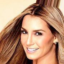

In [7]:
image_prep[:2](PIL.Image.open('data/celeba/img_align_celeba/000001.jpg'))

We can define custom transforms by decorating functions or callable classes with `@transform`. We can also wrap single functions as we do here with `PIL.Image.open`.

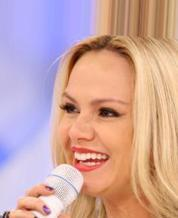

In [8]:
import numpy
import os
import random

images = [f'{dataroot}/{x}' for x in os.listdir(dataroot)]

@transform
def random_image(*args, **kwargs):
    image = random.choice(images)
    return image

load_image = transform(PIL.Image.open)
    
# test the composition
(random_image >> load_image)(())

Now we can combine these steps to get an image tensor sampler.

In [9]:
image_loader = (random_image >> load_image >> image_prep)
image_loader(())

tensor([[[ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         [ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         [ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         ...,
         [-0.8667, -0.8667, -0.8667,  ..., -0.8667, -0.8745, -0.8667],
         [-0.8745, -0.8824, -0.8824,  ..., -0.8824, -0.8902, -0.8745],
         [-0.8980, -0.8824, -0.8902,  ..., -0.8824, -0.8902, -0.8824]],

        [[ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         [ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         [ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         ...,
         [-0.8667, -0.8667, -0.8667,  ..., -0.8667, -0.8745, -0.8667],
         [-0.8745, -0.8824, -0.8824,  ..., -0.8824, -0.8902, -0.8745],
         [-0.8980, -0.8824, -0.8902,  ..., -0.8824, -0.8902, -0.8824]],

        [[ 0.9294,  0.9294,  0.9294,  ...,  0.9451,  0.9451,  0.9451],
         [ 0.9294,  0.9294,  0.9294,  ...,  0

Pytorch layers are first class citizens in PADL, and can be converted to PADL just as before with `@transform`. PADL tracks all torch functionality by composing the class with a PADL object. In the wrapped class, PADL functionality is isolated under methods beginning `.pd_...`.

In [10]:
import torch

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

@transform
class Generator(torch.nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            torch.nn.BatchNorm2d(ngf * 8),
            torch.nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            torch.nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 4),
            torch.nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            torch.nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf * 2),
            torch.nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            torch.nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ngf),
            torch.nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            torch.nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            torch.nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.main(input)
    

@transform
class Discriminator(torch.nn.Module):
    def __init__(self, ngpu):
        super().__init__()
        self.ngpu = ngpu
        self.main = torch.nn.Sequential(
            # input is (nc) x 64 x 64
            torch.nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            torch.nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 2),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            torch.nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 4),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            torch.nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            torch.nn.BatchNorm2d(ndf * 8),
            torch.nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            torch.nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            torch.nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.main(input)
    

netD = Discriminator(ngpu)
netG = Generator(ngpu)

We do something similar for the generator model.

Here we use the keyword `same` which allows for a sort of neat inline lambda function. Standard `lambda` functions are also supported.

You'll also see the `batch` and `unbatch` keywords. These define where the preprocessing ends and forward pass begins, and forward pass ends and postprocessing begins.

When used in batch-mode (see below), everything prior to the `batch` is wrapped into a `torch.utils.data.DataLoader`. Every after `unbatch` is mapped over the individual batch elements of the forward pass. When used in single data-point mode, a single element batch is constructed.

This leads to far less boilerplate, and far fewer errors with batch dimensions, etc.. 

The *main* advantage of this, however, is that it allows the program to isolate all bits of code to run the generation pipeline, and to export these into a single portable saved artifact. This artifact may be then shared, compressed, imported into a serving environment etc..

In [11]:
from padl import batch, unbatch, same
import torch
import numpy


@transform
def generate_noise(dummy):
    return torch.randn(nz, 1, 1)


@transform
def denormalize(x):
    rescaled = 255 * (x * 0.5 + 0.5)
    converted = rescaled.numpy()
    return converted.astype(numpy.uint8)
    
    
generator = (
    generate_noise
    >> batch
    >> netG
    >> unbatch
    >> denormalize
    >> same.transpose(1, 2, 0)
    >> transform(lambda x: PIL.Image.fromarray(x))
)

generator

Compose - "generator":

      │
      ▼ dummy
   0: generate_noise                  
      │
      ▼ args
   1: Batchify(dim=0)                 
      │
      ▼ input
   2: Generator(ngpu=1)               
      │
      ▼ args
   3: Unbatchify(dim=0, cpu=True)     
      │
      ▼ x
   4: denormalize                     
      │
      ▼ args
   5: transpose(1, 2, 0)              
      │
      ▼ x
   6: lambda x: PIL.Image.fromarray(x)

Let's check the PADL-saved output. The saved artifact consists of a small python module, which includes only the bits of code which went into defining the generator. The saver tracks down all global variables, imports, functions, weights and data artifacts necessary for redefining and restoring the pipeline in its entirety. This is all packaged together into a compact, exportable directory.

In [12]:
from padl import save
save(generator, 'test.padl', force_overwrite=True)

saving torch module to test.padl/3.pt


When the keywords `batch` or `unbatch` are used, it's no longer to use the `__call__` methods directly anymore. Instead, the pipeline must be "applied" in one of three modes "train", "eval", and "infer". That's because the pipeline needs to be told how to construct the batch, and whether to include gradients, and functionality only needed in training.

The modes are accessed with three key methods: `train_apply`, `eval_apply`, and `infer_apply`. With `infer_apply`, 
a single data-point batch is created at the `batch` point of the transform, and then these batch dimensions are removed again by the `unbatch` statement.

In `train_apply` and `eval_apply`, a data loader is constructed on the fly and the batches out of this data loader are passed throught the forward pass. The batch is then split into single rows after the `unbatch` statement, and the postprocessing is mapped over these rows. In `train_apply` gradients are activated; in the other modes there are no gradients.

Let's apply the generator. Since it is a sampler, we can just pass an empty tuple or list of empty tuples.

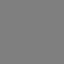

In [13]:
generator.infer_apply(())

In [14]:
output = []
for b in generator.eval_apply([() for _ in range(20)], batch_size=5, num_workers=0):
    output.append(b)
len(output)

20

In [15]:
for b in generator[:3].train_apply([() for _ in range(20)], batch_size=5, flatten=False):
    print(b.shape)

torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])
torch.Size([5, 3, 64, 64])


We can dissect the generating pipeline into preprocessing, forward pass, postprocessing. Let's have a look and 
validate that `generator.pd_preprocess >> generator.pd_forward >> generator.pd_postproces` is equivalent to `generator`.

In [16]:
generator.pd_preprocess

Compose:

      │
      ▼ dummy
   0: generate_noise 
      │
      ▼ args
   1: Batchify(dim=0)

In [17]:
generator.pd_forward

Generator(ngpu=1) - "netG":

   Generator(
     (main): Sequential(
       (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU(inplace=True)
       (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (5): ReLU(inplace=True)
       (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (8): ReLU(inplace=True)
       (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (11): ReLU(inplace=True)
       (12): ConvTranspose2d(64, 3, kernel_size=

In [18]:
generator.pd_postprocess

Compose:

      │
      ▼ args
   0: Unbatchify(dim=0, cpu=True)     
      │
      ▼ x
   1: denormalize                     
      │
      ▼ args
   2: transpose(1, 2, 0)              
      │
      ▼ x
   3: lambda x: PIL.Image.fromarray(x)

These decompositions now also become handy to check the output of the real data pipeline. We can postprocess the tensors coming out of the image-loader with the postprocess part of the generator.

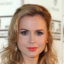

In [19]:
(image_loader >> generator.pd_postprocess[1:])(None)

There are ways to create branches in the workflow using the operators `/`, `+` and `~`. See [here](link_to_the other_notebook) for details.
In the following part, we use `+` to add a label to the discriminator pipeline:

In [20]:
from padl import identity

@transform
def real_label(x):
    return torch.ones_like(x)


criterion = transform(torch.nn.BCELoss())


errD_real = image_loader >> batch >> netD >> (identity + real_label) >> criterion
errD_real

Compose - "errD_real":

      │
      ▼ (args, kwargs)
   0: random_image                                        
      │
      ▼ (fp, mode, formats)
   1: open                                                
      │
      ▼ img
   2: Resize(size=64)                                     
      │
      ▼ img
   3: CenterCrop(size=64)                                 
      │
      ▼ pic
   4: ToTensor()                                          
      │
      ▼ tensor
   5: Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
      │
      ▼ args
   6: Batchify(dim=0)                                     
      │
      ▼ input
   7: Discriminator(ngpu=1)                               
      └──────────────────────────────────────────────────────┐
      │                                                      │
      ▼ args                                                 ▼ x
   8: Identity()                                           + real_label
      │
      ▼ (input, target)
   9: BCELoss(to

In [21]:
@transform
def fake_label(x):
    return torch.zeros_like(x)


make_fake_tensor = generator.pd_preprocess >> generator.pd_forward


errD_fake = (
    same.detach()
    >> netD
    >> identity + fake_label
    >> criterion
)

A test:

In [22]:
errD_fake.infer_apply(torch.randn(1, 3, 64, 64))

tensor(0.6962)

The generator pipeline:

In [23]:
errG = (
    netD
    >> identity + real_label 
    >> criterion
)
errG

Compose - "errG":

      │
      ▼ input
   0: Discriminator(ngpu=1)      
      └─────────────────────────────┐
      │                             │
      ▼ args                        ▼ x
   1: Identity()                  + real_label
      │
      ▼ (input, target)
   2: BCELoss(torch.nn.BCELoss())

We can now create the optimizers and the iterators so that we can do some learning steps. Beware that
PyTorch requires specifying how the seed is set in each worker using `init_worker_fn` -- otherwise it's
possible to identical lines in the batches.

In [24]:
import time

def random_seed_init(i):
    torch.manual_seed(int(i))
    random.seed(int(i))
    numpy.random.seed(int(i))

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

make_fake_tensor.pd_to('cuda')
errD_real.pd_to('cuda')
generator.pd_to('cuda')
errD_fake.pd_to('cuda')
errG.pd_to('cuda')

fake_generator = iter(make_fake_tensor.train_apply(range(1000000), batch_size=batch_size, num_workers=10,
                                                   worker_init_fn=random_seed_init))
errD_real_generator = iter(errD_real.train_apply(range(1000000), batch_size=batch_size, num_workers=10,
                                                 worker_init_fn=random_seed_init))

The training loop based on these pipelines is now super simple and (hopefully) sheds light
on the important structure of how the DC-gan algorithm works.

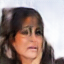

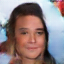

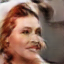

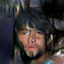

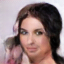

Iteration: 7800; ErrD/real: 0.266; ErrD/fake: 0.144; ErrG: 2.356;


StopIteration: 

In [25]:
from IPython.display import display, clear_output
from IPython.display import clear_output

it = 0
while True:

    fake_tensor = next(fake_generator)

    netD.zero_grad()
    ed_r = next(errD_real_generator)
    ed_r.backward()

    ed_f = errD_fake(fake_tensor)
    ed_f.backward()
    
    optimizerD.step()
    
    netG.zero_grad()
    eg = errG(fake_tensor)
    eg.backward()

    optimizerG.step()
    
    if it % 100 == 0:
        clear_output(wait=True)
        for j in range(5):
            display(generator.infer_apply())
        print(f'Iteration: {it}; ErrD/real: {ed_r:.3f}; ErrD/fake: {ed_f:.3f}; ErrG: {eg:.3f};')
    
    it += 1

Now let's save the trained model!

In [ ]:
save(generator, 'finished.padl')

A really useful feature, and making the finished pipeline super portable, is the ability to reload the full saved pipeline, without any importing or extra definitions. The following cell works, even after restarting the kernel/ or in a new session.

In [ ]:
from padl import load

reloader = load('finished.padl')

We can now try a few sample generations from the trained pipeline, to check we get what we expect.

In [ ]:
reloader.infer_apply()